Created by Andrew Welling
CS337 Project 7

Below is a Semaphore implementation using a condition variable:

In [4]:
import threading

class Semaphore:
    def __init__(self, counter=1):
        self.counter = counter
        self.condition = threading.Condition()

    def acquire(self):
        with self.condition:
            self.counter -= 1
            if self.counter < 0:
                self.condition.wait()

    def release(self):
        with self.condition:
            self.counter += 1
            self.condition.notify()

Now, we must test the behavior of the semaphore using a Buffer (and the consumer/producer problem) to determine that it behaves correctly:

In [3]:
class Buffer:
    def __init__(self, max_prods):
        self.S = Semaphore(1) # mutex
        self.E = Semaphore(10) # size
        self.F = Semaphore(0) # num full spots
        self.buffer = []
        self.num_consumed = 0
        self.num_produced = 0
        self.max_num = max_prods

    def produce_data(self):
        self.num_produced +=1
        return len(self.buffer)

    def consume_data(self):
        self.buffer.pop()
        self.num_consumed +=1

    def producer(self):
        if self.num_produced >= self.max_num:
            return
        data = self.produce_data()
        self.E.acquire()
        self.S.acquire()
        self.buffer.append(data)
        print(f"production, buffer is len {len(self.buffer)}")
        self.S.release()
        self.F.release()

    def consumer(self):
        if self.num_consumed >= self.max_num:
            return
        self.F.acquire()
        self.S.acquire()
        self.consume_data()
        print(f"consumption, buffer is len {len(self.buffer)}")
        self.S.release()
        self.E.release()

    def consumer_loop(self):
        while self.num_consumed < self.max_num:
            self.consumer()

    def producer_loop(self):
        while self.num_produced < self.max_num:
            self.producer()

b = Buffer(20)
t1 = threading.Thread(target=b.producer_loop)
t2 = threading.Thread(target=b.consumer_loop)

t1.start()
t2.start()

t1.join()
t2.join()
print(f"final buffer size: {len(b.buffer)}")

production, buffer is len 1
production, buffer is len 2
production, buffer is len 3
production, buffer is len 4
production, buffer is len 5
production, buffer is len 6
production, buffer is len 7
production, buffer is len 8
production, buffer is len 9
production, buffer is len 10
consumption, buffer is len 9
consumption, buffer is len 8
consumption, buffer is len 7
consumption, buffer is len 6
consumption, buffer is len 5
consumption, buffer is len 4
consumption, buffer is len 3
consumption, buffer is len 2
consumption, buffer is len 1
consumption, buffer is len 0
production, buffer is len 1
production, buffer is len 2
production, buffer is len 3
production, buffer is len 4
production, buffer is len 5
production, buffer is len 6
production, buffer is len 7
production, buffer is len 8
production, buffer is len 9
production, buffer is len 10
consumption, buffer is len 9
consumption, buffer is len 8
consumption, buffer is len 7
consumption, buffer is len 6
consumption, buffer is len 5
con

It appears that the semaphore behaves correctly, as the buffer is treated as it should in this case.

Below is a Dining Philosophers problem and solution using semaphores as the forks and threads as the philosophers:

In [5]:
import time
import random

class Philosopher:
    def __init__(self, id, left, right):
        self.left_fork = left
        self.right_fork = right
        self.id = id

    def think(self):
        print(f"p{self.id} thinks")
        time.sleep(random.uniform(0.2, 0.6))

    def eat(self):
        print(f"p{self.id} eats")
        time.sleep(random.uniform(0.2, 0.6))
        print(f"p{self.id} finishes eating")

    def loop(self, pause=.1):
        '''the standard order of philosophers'''
        for _ in range(5):
            self.think()

            # try and acquire forks
            print(f"p{self.id} is attempting left fork")
            self.left_fork.acquire()
            time.sleep(pause)
            print(f"p{self.id} is attempting right fork")
            self.right_fork.acquire()
            time.sleep(pause)

            self.eat() # eat

            # release forks
            self.right_fork.release()
            print(f"p{self.id} released right fork")

            self.left_fork.release()
            print(f"p{self.id} released left fork")

        print(f"p{self.id} terminated")

    def asym_solution(self, pause=.5):
        '''this solution has odd and even philosophers behave differently in fork order'''
        for _ in range(5):
            self.think()

            # try and acquire forks
            if self.id % 2 == 1: # on odd philosopher, left then right fork
                print(f"p{self.id} is attempting left fork")
                self.left_fork.acquire()
                time.sleep(pause)
                print(f"p{self.id} is attempting right fork")
                self.right_fork.acquire()
                time.sleep(pause)
            else: # on even philosopher, right then left fork
                print(f"p{self.id} is attempting right fork")
                self.right_fork.acquire()
                time.sleep(pause)
                print(f"p{self.id} is attempting left fork")
                self.left_fork.acquire()
                time.sleep(pause)

            self.eat() # eat

            # release forks
            self.right_fork.release()
            print(f"p{self.id} released right fork")

            self.left_fork.release()
            print(f"p{self.id} released left fork")


        print(f"p{self.id} terminated")

num_philo = 5
forks = [Semaphore() for _ in range(num_philo)] # create n semaphores (forks) for n philosophers
philosophers = []

# set up the threads (1 thread is 1 philosopher)
for p_id in range(num_philo):
    philo = Philosopher(p_id,forks[p_id],forks[(p_id+1)%num_philo]) # left fork = processor id, right is the following
    t = threading.Thread(target=philo.asym_solution)
    philosophers.append(t)

# start and join them
for p in philosophers:
    p.start()

for p in philosophers:
    p.join()

p0 thinksp1 thinks

p2 thinks
p3 thinks
p4 thinks
p2 is attempting right fork
p4 is attempting right fork
p3 is attempting left fork
p1 is attempting left fork
p0 is attempting right fork
p2 is attempting left fork
p4 is attempting left fork
p1 is attempting right fork
p2 eats
p4 eats
p2 finishes eating
p2 released right fork
p2 released left fork
p2 thinks
p4 finishes eating
p4 released right fork
p4 released left fork
p4 thinks
p2 is attempting right fork
p1 eats
p3 is attempting right fork
p4 is attempting right fork
p1 finishes eating
p1 released right fork
p1 released left fork
p1 thinks
p3 eats
p1 is attempting left fork
p4 is attempting left fork
p0 is attempting left fork
p3 finishes eating
p3 released right fork
p3 released left fork
p3 thinks
p4 eatsp2 is attempting left fork

p3 is attempting left fork
p4 finishes eating
p4 released right fork
p4 released left fork
p4 thinks
p2 eats
p4 is attempting right fork
p2 finishes eating
p2 released right fork
p2 released left fork
p

This demonstrates an asymmetric solution to the problem that utilizes an algorithm in which odd and even philosophers behave differently. Odd philosophers must pick up the left then right fork, and even must do the opposite. This solution protects against dead lock while utilizing threads as philosophers.

Extension code follows from here:

Extension 1: Does adding more philosophers increase or decrease the chances for deadlock in the first simulation?

Let's test this by running the no solution loop up to a max philosopher value, 20 will be used for testing here with a pause of .3s.

In [9]:
import matplotlib.pyplot as plt
max_philo = 20
deadlocks = []
for num_philo in range(2,max_philo):
    print("==================")
    print(f" {num_philo} of {max_philo}")
    print("==================")
    forks = [Semaphore() for _ in range(num_philo)]
    philosophers = []

    for p_id in range(num_philo):
        philo = Philosopher(p_id,forks[p_id],forks[(p_id+1)%num_philo])
        t = threading.Thread(target=philo.loop, args=(.3,)) # use slight delay
        philosophers.append(t)

    start_time = time.time()

    for p in philosophers:
        p.start()

    for p in philosophers:
        p.join(timeout=10)

    if any([p.is_alive() for p in philosophers]):
        print(f"deadlock occurred at {num_philo}")
        deadlocks.append(True)
    else:
        deadlocks.append(False)

 2 of 20
p0 thinks
p1 thinks
p1 is attempting left fork
p0 is attempting left fork
p1 is attempting right fork
p0 is attempting right fork
deadlock occurred at 2
 3 of 20
p0 thinks
p1 thinks
p2 thinks
p1 is attempting left fork
p2 is attempting left fork
p0 is attempting left fork
p1 is attempting right fork
p2 is attempting right fork
p0 is attempting right fork
deadlock occurred at 3
 4 of 20
p0 thinks
p1 thinks
p2 thinks
p3 thinks
p3 is attempting left fork
p1 is attempting left fork
p0 is attempting left fork
p2 is attempting left fork
p3 is attempting right fork
p1 is attempting right fork
p0 is attempting right fork
p2 is attempting right fork
deadlock occurred at 4
 5 of 20
p0 thinks
p1 thinks
p2 thinks
p3 thinks
p4 thinks
p2 is attempting left fork
p3 is attempting left fork
p0 is attempting left fork
p4 is attempting left fork
p1 is attempting left fork
p2 is attempting right fork
p3 is attempting right fork
p0 is attempting right fork
p4 is attempting right fork
p1 is attempt

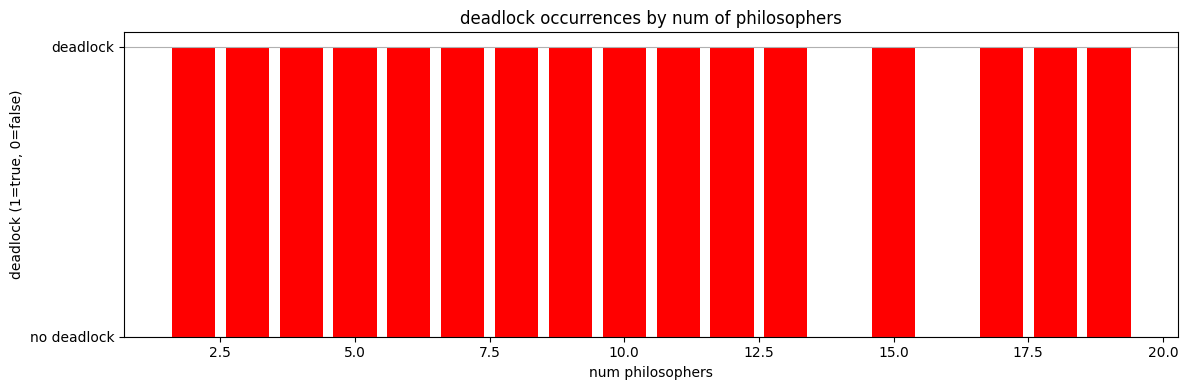

In [10]:
philo_counts = list(range(2, max_philo))
deadlock_ints = [int(d) for d in deadlocks]  # convert to 1/0 from t/f
# plotting our data gathered above
plt.figure(figsize=(12, 4))
plt.bar(philo_counts, deadlock_ints, color=['red' if d else 'green' for d in deadlocks])
plt.xlabel("num philosophers")
plt.ylabel("deadlock (1=true, 0=false)")
plt.title("deadlock occurrences by num of philosophers")
plt.yticks([0, 1], ["no deadlock", "deadlock"])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

It generally appears that deadlock occurred lower at higher philosopher values, with the few rounds that did not deadlock appearing at higher numbers of philosophers using the above data. This may be because more philosophers would need to pick up the left fork at the same time, which could result in less deadlocked runs. It's also worth noting that the number of ways that deadlock could occur would also increase as a result of adding more philosophers, so the above could be incorrect (after all this is only 1 trial) assuming that this plays a larger role in the probability of deadlock than that higher numbers of philosophers are less likely to do the same thing at the same time. Deadlock will also always be a possibility during this run through with no solution, as there is no prevention methods implemented (like in my solution above).

Extension 2: Is there a number of philosophers that can never deadlock?

This can be answered using the above plot, it appears that there is no number of philosophers that can deadlock. The possibility of it is consistent through all numbers of philosophers tried.

Extension 3: Does your solution slow down the simulation in comparison to no solution?

In order to answer this, lets run a set number of iterations of each method (20) and keep the number of philosophers consistent (5)

In [2]:
import matplotlib.pyplot as plt
n_iter = 40 # num of iterations we're testing with
num_philo = 5 # num of philosophers

In [26]:
# no solution run (the loop method)
times = []
for n in range(n_iter):
    print("==================")
    print(f" {n} of {n_iter}")
    print("==================")
    forks = [Semaphore() for _ in range(num_philo)]
    philosophers = []

    for p_id in range(num_philo):
        philo = Philosopher(p_id,forks[p_id],forks[(p_id+1)%num_philo])
        t = threading.Thread(target=philo.loop, args=(0,)) # use no delay
        philosophers.append(t)

    start_time = time.time()

    for p in philosophers:
        p.start()

    for p in philosophers:
        p.join()

    end_time = time.time()
    times.append(end_time-start_time)
print(f"on {n_iter} iterations, no solution, {num_philo} philosophers: finished on avg in {sum(times)/n_iter}s")

 0 of 40
p0 thinks
p1 thinks
p2 thinks
p3 thinks
p4 thinks
p3 is attempting left fork
p3 is attempting right fork
p3 eats
p4 is attempting left fork
p1 is attempting left fork
p1 is attempting right fork
p1 eats
p0 is attempting left fork
p0 is attempting right fork
p2 is attempting left fork
p1 finishes eating
p1 released right fork
p1 released left fork
p1 thinks
p2 is attempting right fork
p0 eats
p3 finishes eating
p3 released right fork
p3 released left fork
p3 thinks
p4 is attempting right fork
p2 eats
p3 is attempting left fork
p2 finishes eating
p2 released right fork
p2 released left fork
p2 thinks
p3 is attempting right fork
p1 is attempting left fork
p0 finishes eating
p0 released right fork
p0 released left fork
p0 thinks
p1 is attempting right fork
p1 eats
p4 eats
p2 is attempting left fork
p0 is attempting left fork
p4 finishes eating
p4 released right fork
p4 released left fork
p4 thinks
p0 is attempting right fork
p3 eats
p1 finishes eating
p1 released right fork
p1 rel

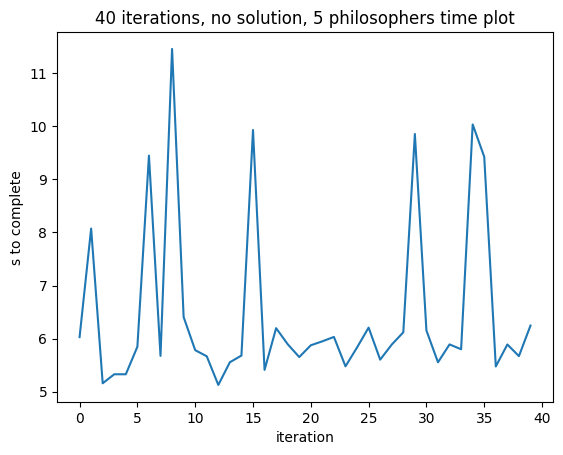

In [27]:
plt.plot(times)
plt.xlabel("iteration")
plt.ylabel("s to complete")
plt.title(f"{n_iter} iterations, no solution, {num_philo} philosophers time plot")
plt.show()

In [6]:
# solution run (asym method)
times = []
for n in range(n_iter):
    print("==================")
    print(f" {n} of {n_iter}")
    print("==================")
    forks = [Semaphore() for _ in range(num_philo)]
    philosophers = []

    for p_id in range(num_philo):
        philo = Philosopher(p_id,forks[p_id],forks[(p_id+1)%num_philo])
        t = threading.Thread(target=philo.asym_solution, args=(0,)) # use no delay
        philosophers.append(t)

    start_time = time.time()

    for p in philosophers:
        p.start()

    for p in philosophers:
        p.join()

    end_time = time.time()
    times.append(end_time-start_time)
print(f"on {n_iter} iterations, with solution, {num_philo} philosophers: finished on avg in {sum(times)/n_iter}s")

 0 of 40
p0 thinks
p1 thinks
p2 thinks
p3 thinks
p4 thinks
p2 is attempting right fork
p2 is attempting left fork
p2 eats
p3 is attempting left fork
p4 is attempting right fork
p4 is attempting left fork
p4 eats
p0 is attempting right fork
p0 is attempting left fork
p1 is attempting left fork
p2 finishes eating
p2 released right fork
p2 released left fork
p2 thinks
p3 is attempting right fork
p4 finishes eating
p4 released right fork
p4 released left fork
p4 thinks
p0 eats
p3 eats
p3 finishes eating
p3 released right fork
p3 released left fork
p3 thinks
p0 finishes eating
p0 released right fork
p0 released left fork
p0 thinks
p1 is attempting right fork
p1 eats
p2 is attempting right fork
p2 is attempting left fork
p4 is attempting right fork
p4 is attempting left fork
p4 eats
p0 is attempting right fork
p1 finishes eating
p1 released right fork
p1 released left fork
p1 thinks
p2 eats
p0 is attempting left fork
p4 finishes eating
p4 released right fork
p4 released left fork
p4 thinks
p

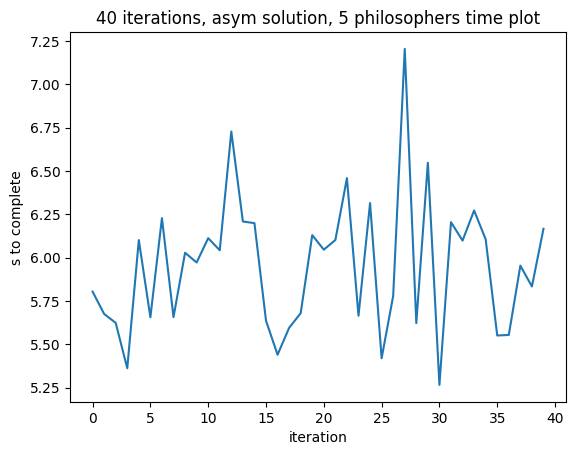

In [8]:
# lets create a plot
plt.plot(times)
plt.xlabel("iteration")
plt.ylabel("s to complete")
plt.title(f"{n_iter} iterations, asym solution, {num_philo} philosophers time plot")
plt.show()

The results above show that on average, the asymmetrical solution is going to be faster than the no solution by about ~.5 seconds to 1 second. Additionally, the solution is more consistent in completion time (varies between 5 and 7 seconds) than running the problem with no solution (varies between 6 seconds and 11 seconds). The better performance achieved by the asymmetrical solution is likely due to the coordination that a solution provides, meaning less threads will be wasting cpu cycles when there blocked and unable to pick up one of their forks. This leads to more efficient cpu usage, thus making the average time to complete the task faster with a solution.

Extension 4: Will the Wifi Solution speed up runtime?

In [11]:
# Implementing the wifi solution:
import time
import random
import semaphore
class Philosopher:
    def __init__(self, id, left, right):
        self.left_fork = left
        self.right_fork = right
        self.id = id

    def think(self):
        print(f"p{self.id} thinks")
        time.sleep(random.uniform(0.2, 0.6))

    def eat(self):
        print(f"p{self.id} eats")
        time.sleep(random.uniform(0.2, 0.6))
        print(f"p{self.id} finishes eating")

    def loop(self, pause=.1):
        '''the standard order of philosophers'''
        for _ in range(5):
            self.think()

            # try and acquire forks
            print(f"p{self.id} is attempting left fork")
            self.left_fork.acquire()
            time.sleep(pause)
            print(f"p{self.id} is attempting right fork")
            self.right_fork.acquire()
            time.sleep(pause)

            self.eat() # eat

            # release forks
            self.right_fork.release()
            print(f"p{self.id} released right fork")

            self.left_fork.release()
            print(f"p{self.id} released left fork")

        print(f"p{self.id} terminated")

    def asym_solution(self, pause=.5):
        '''this solution has odd and even philosophers behave differently in fork order'''
        for _ in range(5):
            self.think()

            # try and acquire forks
            if self.id % 2 == 1: # on odd philosopher, left then right fork
                print(f"p{self.id} is attempting left fork")
                self.left_fork.acquire()
                time.sleep(pause)
                print(f"p{self.id} is attempting right fork")
                self.right_fork.acquire()
                time.sleep(pause)
            else: # on even philosopher, right then left fork
                print(f"p{self.id} is attempting right fork")
                self.right_fork.acquire()
                time.sleep(pause)
                print(f"p{self.id} is attempting left fork")
                self.left_fork.acquire()
                time.sleep(pause)

            self.eat() # eat

            # release forks
            self.right_fork.release()
            print(f"p{self.id} released right fork")

            self.left_fork.release()
            print(f"p{self.id} released left fork")

        print(f"p{self.id} terminated")

    def wifi_solution(self, min_wait=.1, max_wait=.5):
        '''the wifi solution to the dining philo problem'''
        for _ in range(5):
            self.think()

            # try and acquire forks
            print(f"p{self.id} is attempting right fork")
            self.right_fork.acquire()
            if self.left_fork.counter < 0: # if left fork is not avaliable
                # put right fork down and wait random time
                self.right_fork.release()
                time.sleep(random.uniform(min_wait, max_wait))
            else: # if left fork is free, acquire it
                print(f"p{self.id} is attempting left fork")
                self.left_fork.acquire()

                # at this point, we will have both forks
                self.eat() # eat
                # release forks
                self.right_fork.release()
                print(f"p{self.id} released right fork")
                self.left_fork.release()
                print(f"p{self.id} released left fork")

        print(f"p{self.id} terminated")

Now with the wifi solution implemented, lets compare run time to the prior extension

In [12]:
# wifi solution run
times = []
for n in range(n_iter):
    print("==================")
    print(f" {n} of {n_iter}")
    print("==================")
    forks = [Semaphore() for _ in range(num_philo)]
    philosophers = []

    for p_id in range(num_philo):
        philo = Philosopher(p_id,forks[p_id],forks[(p_id+1)%num_philo])
        t = threading.Thread(target=philo.wifi_solution)
        philosophers.append(t)

    start_time = time.time()

    for p in philosophers:
        p.start()

    for p in philosophers:
        p.join()

    end_time = time.time()
    times.append(end_time-start_time)
print(f"on {n_iter} iterations, with solution, {num_philo} philosophers: finished on avg in {sum(times)/n_iter}s")

 0 of 40
p0 thinks
p1 thinks
p2 thinks
p3 thinks
p4 thinks
p0 is attempting right fork
p0 is attempting left fork
p0 eats
p2 is attempting right fork
p2 is attempting left fork
p2 eats
p4 is attempting right fork
p1 is attempting right fork
p3 is attempting right fork
p3 is attempting left fork
p0 finishes eating
p0 released right fork
p0 released left fork
p0 thinks
p4 is attempting left fork
p2 finishes eating
p2 released right fork
p2 released left fork
p2 thinks
p3 eats
p1 is attempting left fork
p1 eats
p0 is attempting right fork
p2 is attempting right fork
p1 finishes eating
p1 released right fork
p1 released left fork
p1 thinks
p0 is attempting left fork
p3 finishes eating
p3 released right fork
p3 released left fork
p3 thinks
p4 eats
p2 is attempting left fork
p2 eats
p1 is attempting right fork
p4 finishes eating
p4 released right fork
p4 released left fork
p4 thinks
p0 eats
p3 is attempting right fork
p3 is attempting left fork
p2 finishes eating
p2 released right fork
p2 re

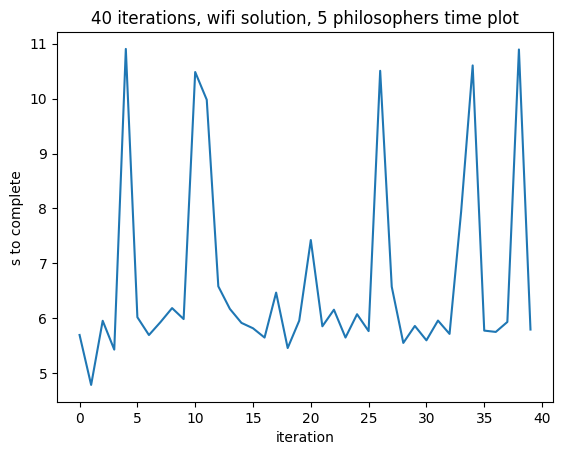

In [13]:
# lets create one last plot
plt.plot(times)
plt.xlabel("iteration")
plt.ylabel("s to complete")
plt.title(f"{n_iter} iterations, wifi solution, {num_philo} philosophers time plot")
plt.show()

Overall, the wifi solution had comparable, if not worse, runtime than running the problem with no solution. This could be due to the excess amount of time that this method has to wait when compared to running the asymmetrical solution. This means that the asymmetrical solution is the fastest of those tested here and the wifi solution is the slowest (as well as most varied) in terms of runtime.